#**🚨 Before Running the Script Please Make Sure you have selected the Run Time as GPU**

#**Step 01: Installing the Packages**

In [1]:
%%capture
#!pip install super-gradients==3.1.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

#**Step 02: Importing all the required libraries**

In [4]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [5]:
from IPython.display import clear_output


In [6]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback



In [7]:
from super_gradients.training import models


#**Step 03: Setting the checkpoint directory and experiment name | Instantiated the trainer**

In [8]:
CHECKPOINT_DIR = 'checkpoints2'
trainer = Trainer(experiment_name='ppe_yolonas_run2', ckpt_root_dir=CHECKPOINT_DIR)

#**Step 04: Exporting the Dataset from Roboflow into the Google Colab Notebook**

In [9]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="IuYv6KOKs5p62rFSLvGa")
project = rf.workspace("objet-detect-yolov5").project("eep_detection-u9bbd")
dataset = project.version(1).download("yolov5")


Extracting Dataset Version Zip to EEP_Detection-1 in yolov5pytorch:: 100%|██████████| 6482/6482 [00:03<00:00, 1694.39it/s]


#**Step 05: Load your dataset parameters into a dictionary**

You'll need to load your dataset parameters into a dictionary, specifically defining:

- path to the parent directory where your data lives
- the child directory names for training, validation, and test (if you have testing set) images and labels
- class names

In [13]:
dataset_params = {
    'data_dir':'C:/Users/rladu/Downloads/EEP_Detection-1',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['Protective Helmet', 'Shield', 'Jacket', 'Dust Mask', 'Eye Wear', 'Glove', 'Protective Boots']
}


#**Step 06: Pass the values for `dataset_params` into the `dataset_params` argument as shown below.**

In [36]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':4,
        'num_workers':1
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':4,
        'num_workers':1
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':4,
        'num_workers':1
    }
)

clear_output()

Indexing dataset annotations: 100%|██████████| 324/324 [00:00<00:00, 6868.40it/s]


#**Step 07: Inspect the Dataset Defined Earlier**

In [37]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

In [38]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [39]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

#**Step 08: Plot a batch of training data with their augmentations applied to see what they look like**

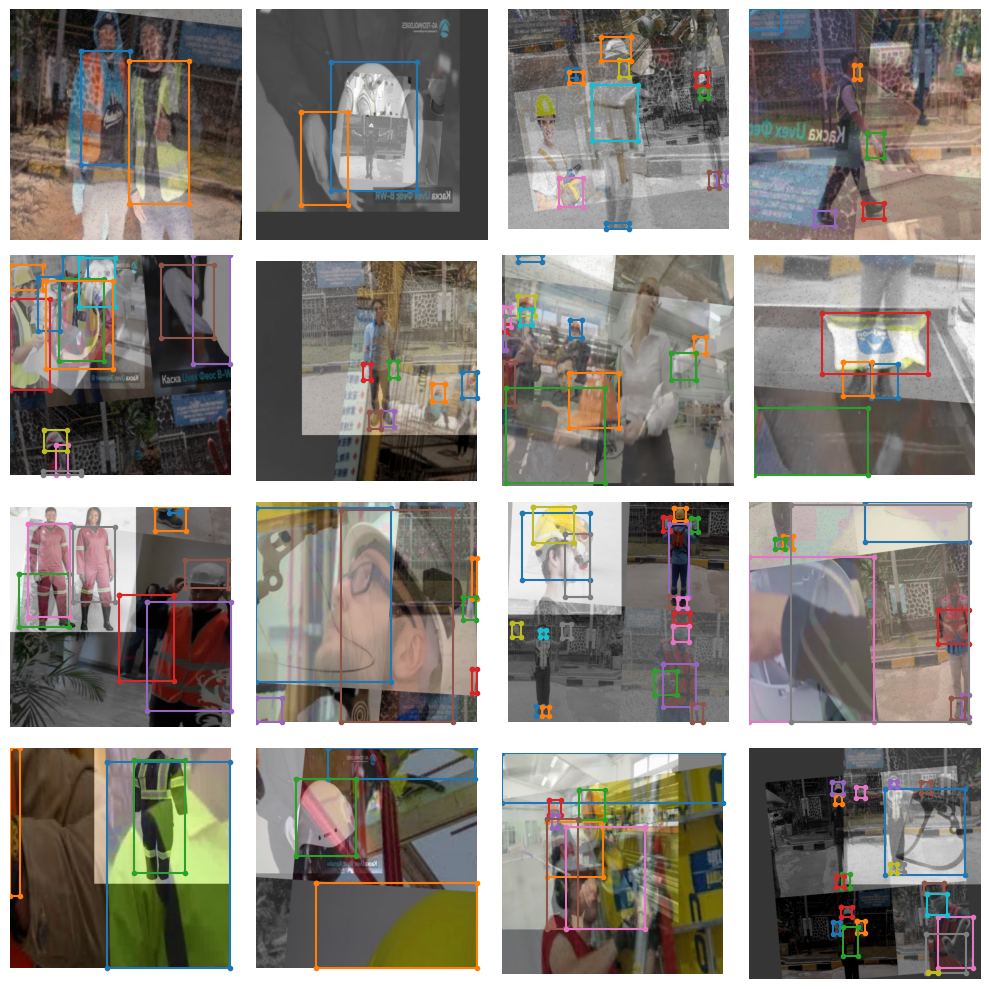

In [40]:
train_data.dataset.plot()

#**Step 09: Instantiating the model**


You saw how to instantiate the model for inference earlier. 

Below is how to instantiate the model for finetuning. Note you need to add the `num_classes` argument here.

Note, for this tutorial we are using `yolo_nas_s`, but SuperGradients has two other flavors of YOLONAS available to you: `yolo_nas_m` and `yolo_nas_l`.

In [41]:
model = models.get('yolo_nas_s', 
                   num_classes=len(dataset_params['classes']), 
                   pretrained_weights="coco"
                   )

#**Step 10: 📊 Define metrics and training parameters**


We need to define the training parameters for your training run. 

Full details about the training parameters can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).


### 🚨 There are a few **mandatory** arguments that we must define for training params 🚨

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

We can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. If you choose to change the defualt parameters of these optimizrs you pass them into `optimizer_params`. 


In [42]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

#**Step 11: Download the Demo Videos**

In [43]:
!gdown "https://drive.google.com/uc?id=1crFwrpMF1OlaJ0ZCZjBNRo9llLEVR8VQ&confirm=t"

In [23]:
!gdown "https://drive.google.com/uc?id=1cTIBNQ1R_7JAOURVv9cJ6P935ym_IkZ0&confirm=t"

In [24]:
!gdown "https://drive.google.com/uc?id=1256pNK0nQnEDT6FRLQAraTRkOY7BSprq&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1cTIBNQ1R_7JAOURVv9cJ6P935ym_IkZ0&confirm=t
To: C:\Users\rladu\Downloads\demo3.mp4

  0%|          | 0.00/20.3M [00:00<?, ?B/s]
  3%|2         | 524k/20.3M [00:00<00:07, 2.48MB/s]
  5%|5         | 1.05M/20.3M [00:00<00:05, 3.46MB/s]
  8%|7         | 1.57M/20.3M [00:00<00:06, 3.11MB/s]
 15%|#5        | 3.15M/20.3M [00:00<00:03, 5.71MB/s]
 21%|##        | 4.19M/20.3M [00:00<00:02, 6.46MB/s]
 26%|##5       | 5.24M/20.3M [00:00<00:02, 6.77MB/s]
 31%|###       | 6.29M/20.3M [00:01<00:01, 7.04MB/s]
 36%|###6      | 7.34M/20.3M [00:01<00:01, 6.97MB/s]
 41%|####1     | 8.39M/20.3M [00:01<00:01, 7.23MB/s]
 46%|####6     | 9.44M/20.3M [00:01<00:01, 7.29MB/s]
 52%|#####1    | 10.5M/20.3M [00:01<00:01, 6.74MB/s]
 57%|#####6    | 11.5M/20.3M [00:01<00:01, 7.41MB/s]
 62%|######1   | 12.6M/20.3M [00:01<00:01, 7.17MB/s]
 67%|######7   | 13.6M/20.3M [00:02<00:00, 7.24MB/s]
 72%|#######2  | 14.7M/20.3M [00:02<00:00, 7.07MB/s]
 77%|#######7  | 15.7M/20.

In [25]:
!gdown "https://drive.google.com/uc?id=15D71z_g8uxZfXSx2ya3sy4n2-eg53meH&confirm=t"


Downloading...
From: https://drive.google.com/uc?id=1256pNK0nQnEDT6FRLQAraTRkOY7BSprq&confirm=t
To: C:\Users\rladu\Downloads\demo4.mp4

  0%|          | 0.00/16.9M [00:00<?, ?B/s]
  3%|3         | 524k/16.9M [00:00<00:05, 2.74MB/s]
  9%|9         | 1.57M/16.9M [00:00<00:03, 4.72MB/s]
 12%|#2        | 2.10M/16.9M [00:00<00:03, 4.55MB/s]
 19%|#8        | 3.15M/16.9M [00:00<00:02, 5.85MB/s]
 25%|##4       | 4.19M/16.9M [00:00<00:01, 6.42MB/s]
 31%|###1      | 5.24M/16.9M [00:00<00:01, 7.00MB/s]
 37%|###7      | 6.29M/16.9M [00:01<00:01, 6.89MB/s]
 44%|####3     | 7.34M/16.9M [00:01<00:01, 7.10MB/s]
 50%|####9     | 8.39M/16.9M [00:01<00:01, 6.94MB/s]
 56%|#####5    | 9.44M/16.9M [00:01<00:01, 6.90MB/s]
 62%|######2   | 10.5M/16.9M [00:01<00:00, 7.04MB/s]
 68%|######8   | 11.5M/16.9M [00:01<00:00, 7.02MB/s]
 75%|#######4  | 12.6M/16.9M [00:01<00:00, 6.86MB/s]
 81%|########  | 13.6M/16.9M [00:02<00:00, 6.02MB/s]
 87%|########7 | 14.7M/16.9M [00:02<00:00, 6.35MB/s]
 93%|#########3| 15.7M/16.

In [26]:
!gdown "https://drive.google.com/uc?id=1iYW9ZAsYAaHkWZhFVwQh_ch41TMt30-Q&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=15D71z_g8uxZfXSx2ya3sy4n2-eg53meH&confirm=t
To: C:\Users\rladu\Downloads\demonew.mp4

  0%|          | 0.00/5.39M [00:00<?, ?B/s]
 10%|9         | 524k/5.39M [00:00<00:01, 2.79MB/s]
 19%|#9        | 1.05M/5.39M [00:00<00:01, 2.58MB/s]
 49%|####8     | 2.62M/5.39M [00:00<00:00, 5.92MB/s]
 68%|######8   | 3.67M/5.39M [00:00<00:00, 6.22MB/s]
 88%|########7 | 4.72M/5.39M [00:00<00:00, 6.16MB/s]
100%|##########| 5.39M/5.39M [00:00<00:00, 5.64MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iYW9ZAsYAaHkWZhFVwQh_ch41TMt30-Q&confirm=t
To: C:\Users\rladu\Downloads\demonew2.mp4

  0%|          | 0.00/1.87M [00:00<?, ?B/s]
 28%|##8       | 524k/1.87M [00:00<00:00, 3.09MB/s]
 56%|#####6    | 1.05M/1.87M [00:00<00:00, 4.00MB/s]
100%|##########| 1.87M/1.87M [00:00<00:00, 4.84MB/s]
100%|##########| 1.87M/1.87M [00:00<00:00, 4.49MB/s]


#**Step 12: 🦾 Training the model**

You've covered a lot of ground so far:

✅ Instantiated the trainer

✅ Defined your dataset parameters and dataloaders

✅ Instantiated a model

✅ Set up your training parameters

### ⏳ Now, its time to train a model 

Training a model using a SuperGradients is done using the `trainer`.

It's as easy as...

In [44]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

Downloading...
From: https://drive.google.com/uc?id=1crFwrpMF1OlaJ0ZCZjBNRo9llLEVR8VQ&confirm=t
To: C:\Users\rladu\Downloads\demo.mp4

  0%|          | 0.00/42.9M [00:00<?, ?B/s]
  1%|1         | 524k/42.9M [00:00<00:12, 3.36MB/s]
  4%|3         | 1.57M/42.9M [00:00<00:09, 4.27MB/s]
  7%|7         | 3.15M/42.9M [00:00<00:06, 6.53MB/s]
 10%|9         | 4.19M/42.9M [00:00<00:05, 6.65MB/s]
 12%|#2        | 5.24M/42.9M [00:00<00:05, 6.73MB/s]
 15%|#4        | 6.29M/42.9M [00:01<00:05, 6.68MB/s]
 17%|#7        | 7.34M/42.9M [00:01<00:04, 7.37MB/s]
 20%|#9        | 8.39M/42.9M [00:01<00:04, 7.30MB/s]
 22%|##1       | 9.44M/42.9M [00:01<00:04, 7.21MB/s]
 24%|##4       | 10.5M/42.9M [00:01<00:04, 7.16MB/s]
 27%|##6       | 11.5M/42.9M [00:01<00:04, 7.35MB/s]
 29%|##9       | 12.6M/42.9M [00:01<00:04, 7.11MB/s]
 32%|###1      | 13.6M/42.9M [00:02<00:04, 6.97MB/s]
 34%|###4      | 14.7M/42.9M [00:02<00:03, 7.11MB/s]
 37%|###6      | 15.7M/42.9M [00:02<00:03, 6.97MB/s]
 39%|###9      | 16.8M/42.9

#**Step 13: 🏆 Get the best trained model**

In [48]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="C:/Users/rladu/Downloads/checkpoints2/ppe_yolonas_run2/RUN_20231202_111434_013734/ckpt_best.pth")

#**Step 14: 🧐 Evaluating the best trained model on the test set**

In [49]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1, 
                                                   top_k_predictions=300, 
                                                   num_cls=len(dataset_params['classes']), 
                                                   normalize_targets=True, 
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, 
                                                                                                          nms_top_k=1000, 
                                                                                                          max_predictions=300,                                                                              
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing: 100%|██████████| 81/81 [00:13<00:00, 10.03it/s]

{'PPYoloELoss/loss_cls': 0.94202524,
 'PPYoloELoss/loss_iou': 0.41844007,
 'PPYoloELoss/loss_dfl': 0.49293542,
 'PPYoloELoss/loss': 1.853401,
 'Precision@0.50': 0.048302061855793,
 'Recall@0.50': 0.9533729553222656,
 'mAP@0.50': 0.7314400672912598,
 'F1@0.50': 0.08952785283327103}

Testing: 100%|██████████| 81/81 [00:13<00:00,  5.98it/s]


#**Step 15: 🔮 Predicting with the best model**



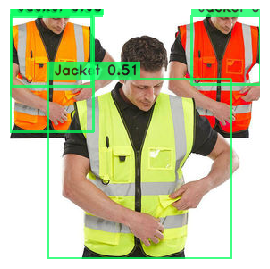

In [53]:
img_url = "C:/Users/rladu/Downloads/Reflective-Vest.jpg"
best_model.predict(img_url).show()

#**Step 16: Testing on Video 1**

In [57]:
input_video_path = f"C:/Users/rladu/Downloads/safety helmet.mp4"
output_video_path = "detections2.mp4"

In [58]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [59]:
best_model.to(device).predict(input_video_path).save(output_video_path)

Processing Video: 100%|██████████| 819/819 [00:43<00:00, 18.93it/s]


#**Display the Output Video**

In [ ]:
!rm '/content/result_compressed.mp4'

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = '/content/detections.mp4'

# Compressed video path
compressed_path = "/content/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

#**Step 17: Testing on Video 2**

In [ ]:
input_video_path = f"/content/demonew2.mp4"
output_video_path = "detections.mp4"

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [ ]:
best_model.to(device).predict(input_video_path).save(output_video_path)

#**Display the Output Video**

In [ ]:
!rm '/content/result_compressed.mp4'

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = '/content/detections.mp4'

# Compressed video path
compressed_path = "/content/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)